# Analyze model

First: Create model similar to `exp_regression.ipynb`

In [12]:
# To make realitve imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, COL_STUDENT, COL_STUDENT_PRED, COL_SALARY, COL_SALARY_PRED
from src.dataLoading import getAllCourses, getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedBruttoSalary
import numpy as np
from statsmodels.tsa.api import VAR
import statsmodels
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

In [13]:
courses = getAllCourses() # if you use all options, dont put that in the title down marked  there
courses = ['"Informatik"']
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = courses, years = interestingYears)

SECTOR = ('WZ08-62', 'Dienstleistungen der Informationstechnologie')
inflationAdjasutedBruttoSalary = getInflationAdjustedBruttoSalary(SECTOR)
salaries = getSalaries()
SALARY_YEARS = salaries.index.levels[2]

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2
#Use average of 2011 and 2013 for 2012
#graduatesInBW[5] = newVal

#Use the averrage and add 1/4 of the missing student to 2012 and the next 3 years
diff = graduatesInBW[5] - newVal
graduatesInBW[5] = newVal + diff/4
graduatesInBW[6] = graduatesInBW[6] + diff/4
graduatesInBW[7] = graduatesInBW[7] + diff/4
graduatesInBW[8] = graduatesInBW[8] +  diff/4

Create cummulative inflation:
2.3 -> 1.023
2.8 -> 1.051644
0.2 -> 1.053747288
1.1 -> 1.065338508168
2.5 -> 1.0919719708722
2.2 -> 1.1159953542313885
1.6 -> 1.1338512798990907
0.8 -> 1.1429220901382835
0.7 -> 1.1509225447692513
0.4 -> 1.1555262349483282
1.7 -> 1.1751701809424497
1.9 -> 1.1974984143803562
1.4 -> 1.2142633921816812
0.4 -> 1.219120445750408
3.2 -> 1.258132300014421

Adjust salary for inflation:
4211.5 -> 4116.813294232649
4251.0 -> 4155.4252199413495
4302.5 -> 4091.2133763897286
4317.0 -> 4105.001312231135
4349.0 -> 4127.175509276376
4375.0 -> 4151.8493568829945
4428.0 -> 4156.425367195795
4491.5 -> 4216.030834859963
4538.0 -> 4155.784325100693
4593.0 -> 4206.151918287238
4584.0 -> 4107.54398091299
4598.0 -> 4120.0888360030385
4597.0 -> 4054.323597367301
4655.5 -> 4105.9176653346685
4805.0 -> 4204.136083692842
4854.0 -> 4247.008647293455
4927.5 -> 4281.348056300275
5012.5 -> 4355.20185331408
4930.0 -> 4266.4544091640255
4999.0 -> 4326.1674627608445
5064.0 -> 4309.163117071

### Test model accuracy
Delete last 2 timesteps and use them as a test set.

In [14]:
PAST_STEPS = 4
PREDICTION_STPES = 2

In [15]:
completeData = np.column_stack((totalStudents, inflationAdjasutedBruttoSalary, graduatesInBW.repeat(2)))
trainData, testData = np.split(completeData, [len(completeData) - PREDICTION_STPES])
completeDataDF = pd.DataFrame(completeData, index = YEARS[3:-4], columns = ['students', 'sallary', 'graduates'])

In [16]:
model = VAR(completeDataDF)

results = model.fit(maxlags=PAST_STEPS)
# Forecasting
lagged_values = trainData[-PAST_STEPS:]  # Use the last available values as lagged values
forecast = results.forecast(lagged_values, steps=PREDICTION_STPES)

c:\Users\lisam\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\lisam\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
print("These are the absoulue diffrences between the predicted and the actual values")
np.set_printoptions(suppress=True)
absDiffernce = abs(forecast - testData)
print(absDiffernce)

print("\nThese are the percentage differences between the predicted and the actual values")
percentage_difference = (absDiffernce / testData) * 100
print(percentage_difference)

These are the absoulue diffrences between the predicted and the actual values
[[  2.83324356  33.8600292   70.63639068]
 [ 26.94026025  49.23095737 867.03128431]]

These are the percentage differences between the predicted and the actual values
[[0.23223308 0.77090837 0.16022772]
 [2.15522082 1.10753791 1.96672629]]


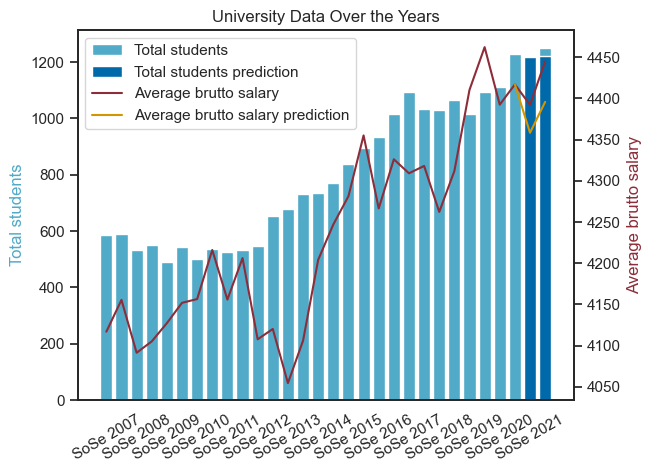

In [18]:
fig, ax1 = plt.subplots()
plt.title('University Data Over the Years')
plt.xticks(rotation=30)

ax1.set_ylabel('Total students', color=COL_STUDENT)
ax1.bar(interestingYears[:-PREDICTION_STPES], trainData[:, 0], color=COL_STUDENT, label='Total students')
ax1.bar(interestingYears[-PREDICTION_STPES:], testData[:, 0], color=COL_STUDENT)
ax1.bar(interestingYears[-PREDICTION_STPES:], forecast[:, 0], color=COL_STUDENT_PRED, label='Total students prediction')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
forecastWithPrevious = np.concatenate((trainData[-1, :].reshape(1, -1), forecast))

ax2.set_ylabel('Average brutto salary', color=COL_SALARY)
ax2.plot(interestingYears, completeData[:, 1], color=COL_SALARY, label='Average brutto salary')
ax2.plot(interestingYears[-PREDICTION_STPES -1:], forecastWithPrevious[:, 1], color=COL_SALARY_PRED, label='Average brutto salary prediction')


# Create one legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Get current ticks, keep only every second tick
locs, labels = plt.xticks()
plt.xticks(locs[::2], labels[::2])

plt.show()

Documentation Link: [statsmodel](https://www.statsmodels.org/dev/vector_ar.html#statistical-tests)

In [19]:
with open('summary.txt', 'w') as file:
    file.write(str(results.summary()))

<Axes: >

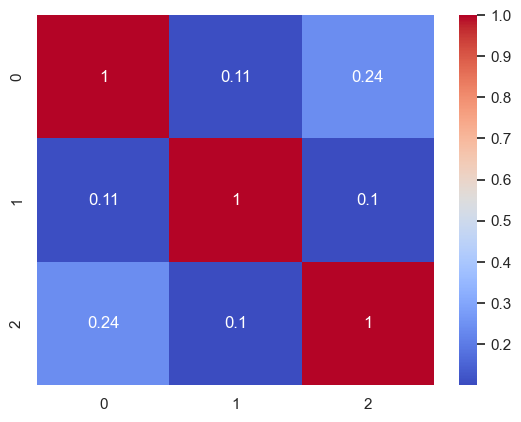

In [20]:
import seaborn as sns
resudiuals = results.resid
correlationMatrix = np.corrcoef(resudiuals, rowvar=False)
sns.set(style="white")
sns.heatmap(correlationMatrix, cmap="coolwarm", annot=True, )

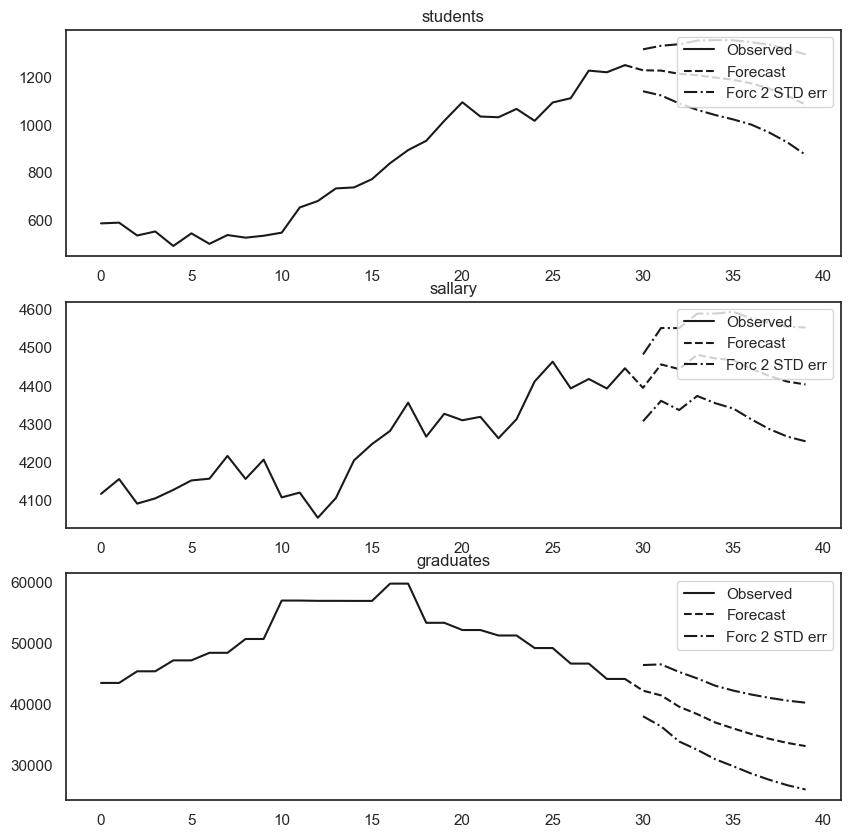

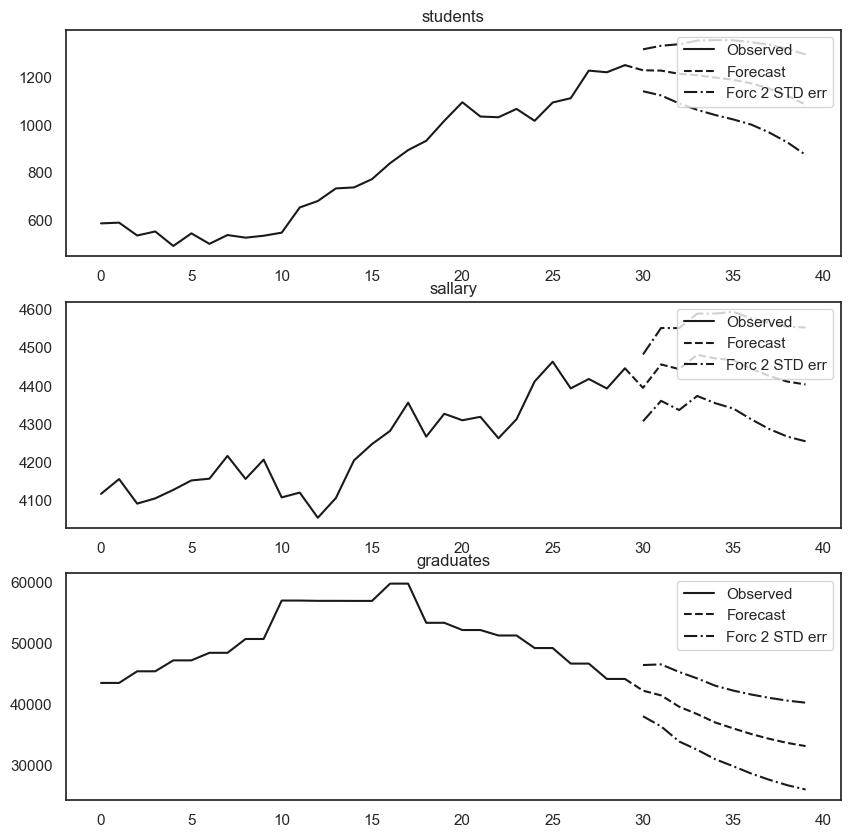

In [21]:
results.plot_forecast(10)

In [22]:
results.test_normality()